In [25]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

import numpy as np
from data import Dataset

DATA_DIR = "../data/Problem_01"
RESULT_DIR = "../results/Problem_01"

dataset = Dataset(DATA_DIR, RESULT_DIR, fps=5)

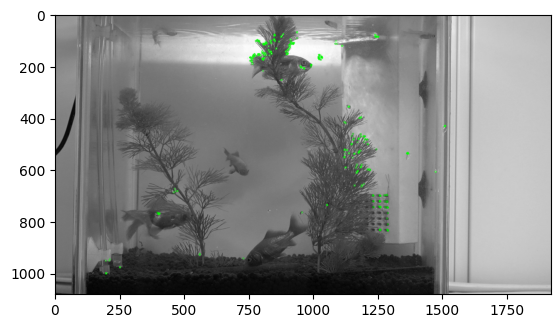

In [26]:
import cv2
import matplotlib.pyplot as plt

imgs = dataset.get_images([0, 1, 2])

# ax1 = plt.subplot(1,2,1)
# ax2 = plt.subplot(1, 2, 2)
# ax1.imshow(imgs[0])
# ax2.imshow(imgs[1])

# グレースケールにしてコーナ特徴点を抽出
prev_frame = imgs[0]
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)

orb = cv2.ORB_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(prev_gray,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.

img2 = cv2.drawKeypoints(prev_gray, kp1, None, color=(0,255,0), flags=0)
plt.imshow(img2)

# Detection (By Takenobu 2022/09/16)

In [27]:
from mmdet.apis import init_detector, inference_detector
import sys
# Path追加
sys.path.append('../')
from common.visulaizations import draw_bb
import cv2
import imageio
import matplotlib.pyplot as plt

In [28]:
import os

# detection部分を関数化
def detection(img):
    config_path = '/home/workspace/kiyama/SummerCamp2022/configs/faster_rcnn_r50_fpn.py'
    weight_path = '/home/workspace/kiyama/SummerCamp2022/work_dirs/faster_rcnn_r50_fpn/latest.pth'
    

    model = init_detector(config_path, weight_path, device ='cuda:1')
    
    result_dir = '/home/workspace/kiyama/SummerCamp2022/notebooks/nobu_result'

    score_th = 0.5

    #img = imageio.imread(img)
    result = inference_detector(model, img)
    
    return result

    '''
    det_img = draw_bb(img, result, score_th)
    det_img2 = cv2.cvtColor(det_img, cv2.COLOR_BGR2RGB)
    #plt.imshow(det_img2)
    cv2.imwrite(result_dir+os.path.basename(img_path), det_img)
    '''

# Try to make Object Tracking

load checkpoint from local path: /home/workspace/kiyama/SummerCamp2022/work_dirs/faster_rcnn_r50_fpn/latest.pth


/home/workspace/kiyama/SummerCamp_2022_personal/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


Tracking Object
{}
CUR FRAME LEFT PT
[(948, 563), (1076, 45), (440, 50), (394, 102), (1404, 82), (884, 204), (852, 886), (695, 573), (379, 793), (871, 197), (370, 779)]
load checkpoint from local path: /home/workspace/kiyama/SummerCamp2022/work_dirs/faster_rcnn_r50_fpn/latest.pth
Tracking Object
{0: (951, 562), 1: (1076, 45), 2: (1403, 82), 3: (392, 97), 4: (445, 53), 5: (887, 204), 6: (854, 886), 7: (696, 572), 8: (381, 794), 9: (877, 196), 10: (877, 196), 11: (370, 780), 12: (370, 780)}
CUR FRAME LEFT PT
[(951, 562), (1076, 45), (1403, 82), (392, 97), (445, 53), (887, 204), (854, 886), (696, 572), (381, 794), (877, 196), (370, 780)]
load checkpoint from local path: /home/workspace/kiyama/SummerCamp2022/work_dirs/faster_rcnn_r50_fpn/latest.pth
Tracking Object
{0: (951, 562), 1: (1076, 45), 2: (1403, 82), 3: (392, 97), 4: (445, 53), 5: (887, 204), 6: (854, 886), 7: (696, 572), 8: (381, 794), 9: (877, 196), 10: (877, 196), 11: (370, 780), 12: (370, 780), 13: (950, 561), 14: (1075, 44), 

KeyboardInterrupt: 

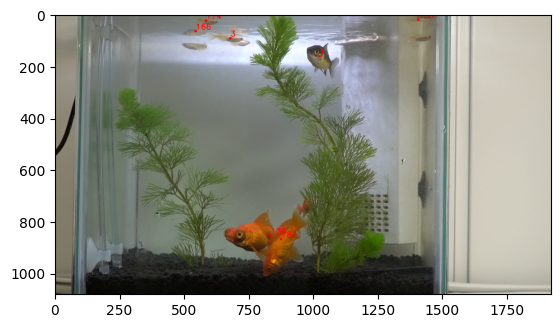

In [29]:
from errno import ESTALE
import math
from tkinter import E
from turtle import color
import cv2

# path to vidio
video_path = '/home/workspace/kiyama/SummerCamp2022/data/Problem_01/Problem_01.MP4'
cap = cv2.VideoCapture(video_path)

# Initialize Counter
count = 0
center_points_prev_frame = []

tracking_objects = {}
track_id = 0


while True:

    # Prepare for frame
    ret, frame = cap.read()

    # Point Current frame
    center_points_cur_frame = []    
    
    # If video is finished, escape from loop
    if not ret:
        break

    # Detection
    result = detection(frame)

    # Calculate the Center of detected fishes
    # each of loop is category of fish
    for category in result:
        # each of loop is data of detected fish
        for detected in category:
            x, y, x_w, y_h, score = detected[0:5]

            # Calculate center
            cx = int((x+x_w)/2)
            cy = int((y+y_h)/2)
            center_points_cur_frame.append((cx,cy))

            #cv2.circle(frame, (cx, cy), 10 , (0,0,255),-1)

    # Tracking
    # Only at the begining we compare previous and current freame
    if count <= 2:      
        for pt in center_points_cur_frame:
            for pt2 in center_points_prev_frame:
                # Calculate the distance between two points as Euclidean Distance
                distance = math.hypot(pt2[0]-pt[0], pt2[1]-pt2[1])
                # If distance is lower than 10, regard it as a same point
                if distance < 10:
                    tracking_objects[track_id] = pt
                    track_id += 1
    else:
        tracking_objects_copy = tracking_objects.copy()
        center_points_cur_frame_copy = center_points_cur_frame.copy()
           
        for object_id, pt2 in tracking_objects_copy.items():
            object_exits = False
            for pt in center_points_cur_frame:            
                distance = math.hypot(pt2[0]-pt[0], pt2[1]-pt2[1])
                # Update IDs position
                if distance < 30:
                    tracking_objects[object_id] = pt
                    object_exits = True
                    if pt in center_points_cur_frame:
                        center_points_cur_frame.remove(pt)
                        continue
            # Remove IDs lost
            if not object_exits:
                tracking_objects.pop(object_id)
    
        # Add new IDs found 
        for pt in center_points_cur_frame:
            tracking_objects[track_id] = pt
            track_id += 1


  
    for object_id, pt in  tracking_objects.items():
        cv2.circle(frame, pt, 5, (0,0, 255), -1)
        cv2.putText(frame, text=str(object_id), org=(pt[0], pt[1]-7), color=(0,0, 255),thickness=2,fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.0)

    print("Tracking Object")
    print(tracking_objects)

    print("CUR FRAME LEFT PT")
    print(center_points_cur_frame)
    
    # Make a copy of the points
    center_points_prev_frame = center_points_cur_frame.copy()

    count += 1

    # Debug
    
    frame2 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame2)
    cv2.imwrite("/home/workspace/kiyama/SummerCamp2022/notebooks/nobu_result/tracking_frame{}.png".format(count),frame)
    

    '''
    ## control the number of frames
    if count == 2:
        break
    '''

    # print(x,y,x_w,y_h,score)


cap.release()


## Video of Result 

In [6]:
import cv2

img_dir = "/home/workspace/kiyama/SummerCamp2022/notebooks/nobu_result"
# encoder(for mp4)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# output file name, encoder, fps, size(fit to image size)
video = cv2.VideoWriter('tracking_video_test1.mp4',fourcc, 30.0, (1920, 1080))

for i in range(1,421):
    img_path = img_dir + "/tracking_frame{}.png".format(i)
    img = cv2.imread(img_path)
    print(img)
    video.write(img)

video.release()
print('written')

[[[142 151 157]
  [142 151 157]
  [142 151 157]
  ...
  [175 191 198]
  [175 191 198]
  [175 191 198]]

 [[142 151 157]
  [142 151 157]
  [142 151 157]
  ...
  [173 189 196]
  [173 189 196]
  [173 189 196]]

 [[142 151 157]
  [142 151 157]
  [142 151 157]
  ...
  [171 188 192]
  [171 188 192]
  [171 188 192]]

 ...

 [[ 17  34  32]
  [ 18  35  33]
  [ 17  34  32]
  ...
  [183 203 205]
  [185 203 205]
  [185 203 205]]

 [[  3  20  18]
  [  0  17  15]
  [  2  19  17]
  ...
  [184 204 206]
  [187 205 207]
  [189 207 209]]

 [[  0  15  13]
  [  0  15  13]
  [  0  15  13]
  ...
  [185 205 207]
  [186 204 206]
  [184 202 204]]]
[[[142 151 157]
  [142 151 157]
  [142 151 157]
  ...
  [175 191 198]
  [175 191 198]
  [175 191 198]]

 [[142 151 157]
  [142 151 157]
  [142 151 157]
  ...
  [172 188 195]
  [172 188 195]
  [172 188 195]]

 [[142 151 157]
  [142 151 157]
  [142 151 157]
  ...
  [171 188 192]
  [171 188 192]
  [171 188 192]]

 ...

 [[ 14  31  29]
  [ 17  34  32]
  [ 17  34  32]
  ..

In [7]:
img = cv2.imread("/home/workspace/kiyama/SummerCamp2022/notebooks/nobu_result/tracking_frame1.png")
img.shape

(1080, 1920, 3)

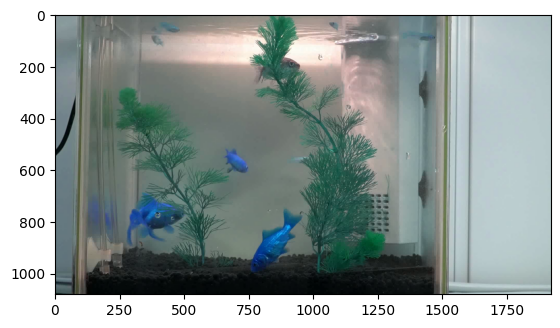

In [8]:
import cv2
import matplotlib.pyplot as plt
cap = cv2.VideoCapture("/home/workspace/kiyama/SummerCamp2022/notebooks/tracking_video_test1.mp4")
fet, frame = cap.read()
plt.imshow(frame)